In [0]:
import gensim
import keras
from gensim.models import word2vec
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from keras.optimizers import adam
import keras.backend as K
import math
from scipy import sparse

Using TensorFlow backend.


# Download & Prepare Dataset

We downloaded all the different components needed for the cleaned dataset we previously generated.

In [0]:
import urllib.request, json 
with urllib.request.urlopen("https://people.ucsc.edu/~gcollelu/encoded_recipes.json") as url:
    recipes_encoded = json.loads(url.read().decode())
with urllib.request.urlopen("https://people.ucsc.edu/~gcollelu/recipes.json") as url:
    recipes = json.loads(url.read().decode())
with urllib.request.urlopen("https://people.ucsc.edu/~gcollelu/flat_steps.json") as url:
    flat_steps = json.loads(url.read().decode())
with urllib.request.urlopen("https://people.ucsc.edu/~gcollelu/flat_ingredients.json") as url:
    flat_ingredients = json.loads(url.read().decode())


In [0]:
print(json.dumps(recipes_encoded[6425], indent=2))
print(json.dumps(recipes[6425], indent=2))

{
  "67132": [
    [
      362429,
      0
    ],
    [
      176282,
      1
    ],
    [
      395500,
      2
    ],
    [
      395500,
      2
    ],
    [
      395500,
      2
    ],
    [
      395500,
      2
    ],
    [
      395500,
      2
    ],
    [
      395500,
      2
    ],
    [
      395500,
      2
    ],
    [
      395500,
      2
    ],
    [
      395500,
      2
    ],
    [
      395500,
      2
    ],
    [
      395500,
      2
    ],
    [
      360632,
      3
    ],
    [
      235512,
      4
    ],
    [
      235512,
      4
    ],
    [
      418616,
      5
    ],
    [
      418616,
      5
    ],
    [
      418616,
      5
    ],
    [
      239999,
      7
    ],
    [
      239999,
      7
    ],
    [
      239999,
      7
    ],
    [
      239999,
      7
    ],
    [
      239999,
      7
    ],
    [
      54809,
      8
    ],
    [
      54809,
      8
    ],
    [
      54809,
      8
    ],
    [
      54809,
      8
    ],
    [
   

## Converting previously encoded recipes to 15x20 matrix

Now we need to represent the matrix in a more concise way. We do so, by translating the 2D 452362x84253 sparse matrix into a 15x20 dense matrix in which each entry represents an encoding of `(ingredient, step, step_position)`. This way, we will be able to use the matrix for our model.


In [0]:
def encode_triplet(ingredient, step, position):
    # Padding indices
    position = "%0*d" % (2, position)
    step = "%0*d" % (6, step)
    ingredient = "%0*d" % (5, int(ingredient))
    encoded = ingredient + step + position
    return int(encoded)
    

In [0]:
def decode_triplet(encoded_triplet):
    encoded_triplet = int(encoded_triplet)
    position = encoded_triplet % 100
    encoded_triplet =  encoded_triplet // 100
    step = encoded_triplet % 1000000
    encoded_triplet = encoded_triplet // 1000000
    ingredient = str(encoded_triplet)
    return (ingredient, step, position)

In [0]:
def encode_recipe_matrix(encoded_recipe):
    recipe_en = np.zeros(shape=(15,20), dtype=np.uint64)
    ingredient_count = 0
    steps_seen = {}
    for ingredient_id in encoded_recipe:
        step_count = 0
        for (step_id, position) in encoded_recipe[ingredient_id]:
            encoded_triplet = encode_triplet(ingredient_id, step_id, position)
            recipe_en[ingredient_count][step_count] = encoded_triplet
            if step_id not in steps_seen:
                steps_seen[step_id] = True
                step_count += 1
        ingredient_count += 1
    return recipe_en

In [0]:
def decode_recipe_matrix(matrix):
    rows = matrix.shape[0]
    cols = matrix.shape[1]
    recipe_encoded = {}
    
    for i in range(0, rows):
        for j in range(0, cols):
            if matrix[i][j] < 0.5 and matrix[i][j] > -0.5 :
                continue
            (ingredient, step, position) = decode_triplet(matrix[i][j])
            if not position == 0:  
                if ingredient not in recipe_encoded:
                    recipe_encoded[ingredient] = []
                recipe_encoded[ingredient].append([step, position])
    return recipe_encoded

In [0]:
def decode_recipe(encoded_recipe, flat_ingredients, flat_steps):
    decoded_recipe = {}
    decoded_recipe["ingredients"] = set([])
    decoded_recipe["steps"] = set([])
    for ingredient_id in encoded_recipe:
        ingredient_id = str(int(ingredient_id) % 84253)
        decoded_recipe["ingredients"].add(flat_ingredients[int(ingredient_id)])
        for (step_id, position) in encoded_recipe[ingredient_id]:
            step_id = step_id % 452362
            try:
                decoded_recipe["steps"].add((flat_steps[step_id], position))
            except IndexError:
                print(step_id)
    
    decoded_recipe["ingredients"] = list(decoded_recipe["ingredients"])
    decoded_recipe["steps"] = list(decoded_recipe["steps"])
    decoded_recipe['steps'] =  sorted(decoded_recipe['steps'], key=lambda tup: tup[1])
    decoded_recipe['steps'] = [ seq[0] for seq in decoded_recipe['steps'] ]

    return decoded_recipe

In [0]:
def full_decode_to_original(matrix_recipe, flat_ingredients, flat_steps):
    decoded_matrix_json = decode_recipe_matrix(matrix_recipe)
    original_recipe = decode_recipe(decoded_matrix_json, flat_ingredients, flat_steps)
    return original_recipe
    

In [0]:
# Testing
print(json.dumps(recipes[200], indent=2))
# print(recipes_encoded[200])
encoded_matrix = encode_recipe_matrix(recipes_encoded[200])
decoded_matrix_json = decode_recipe_matrix(encoded_matrix)
# print(decoded_matrix_json)
decoded_recipe = decode_recipe(decoded_matrix_json, flat_ingredients, flat_steps)
print(json.dumps(decode_recipe, indent=2))

In [0]:
def recipes2small_matrices(encoded_recipes):
    matrices = []
    for i in tqdm(range(len(encoded_recipes))):
        recipe = encoded_recipes[i]
        matrices.append(encode_recipe_matrix(recipe))
    matrices = np.stack(matrices)
    return matrices  

In [0]:
matrices = recipes2small_matrices(recipes_encoded)
print(matrices.shape)
# matrices.max()

100%|██████████| 76549/76549 [00:08<00:00, 8736.65it/s]


(76549, 15, 20)


In [0]:
def load_data(recipes_matrices):
    train_length = math.floor(len(recipes_matrices)/2)
    train_data = np.array([np.array(recipe) for recipe in recipes_matrices[:train_length]])
    test_data = np.array([np.array(recipe) for recipe in recipes_matrices[train_length:]])
    return (train_data, test_data)

In [0]:
X_train, X_test = load_data(matrices)
X_train.shape

(38274, 15, 20)

## Preprocessing
We need to flatten the recipe matrix as the fully connected input layer expects that. Also, as the generator uses the tanh activation in the output layer, we scale all the data images to have values between -1 and 1.

In [0]:
def preprocess(x):    
    x = x.reshape(-1, 300) # 300 = 15*20
    x = np.float64(x)
    x = (x / 8425231679608 -0.5) * 2
    x = np.clip(x, -1, 1)
    return x

In [0]:
X_train_real = preprocess(X_train)
X_test_real  = preprocess(X_test)

## Deprocessing
We also need a function to reverse the preprocessing so that we can display generated recipes.

In [0]:
def deprocess(x):
    x = (x / 2)
    x += x + 0.5
    x = x*8425231679608
    x = np.clip(x, 0, 8425231679608)
    x = np.uint64(x)
    x = x.reshape(15, 20)
    return x

In [0]:
for i in range(20):
    print("Preprocessed")
    print(X_train_real[i])
    recipe = deprocess(X_train_real[i])
    original_recipe = full_decode_to_original(recipe, flat_ingredients, flat_steps)
    print(json.dumps(original_recipe, indent=2))
    break
    

# GAN Implementation

Now we need to have the model for the generator and the discriminator.

# Generator

We need to implement a generator model

In [0]:
def make_latent_samples(n_samples, sample_size):
    #return np.random.uniform(-1, 1, size=(n_samples, sample_size))
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

The sample size is a hyperparameter. Below, we use a vector of 100 randomly generated number as a sample.

In [0]:
make_latent_samples(1, 300) # generates one sample

The generator is a simple fully connected neural network with one hidden layer with the leaky ReLU activation. It takes one latent sample (100 values) and produces 300 (=15x20) data points which represent a digit image.



## GAN

We connect the generator and the discriminator to produce a GAN.

It takes the latent sample, and the generator inside GAN produces a digit image which the discriminator inside GAN classifies as real or fake.

If the generated digit image is so realistic, the discriminator in the GAN classifies it as real, which is what we want to achieve.

We set the discriminator inside the GAN not-trainable, so it is merely evaluating the quality of the generated image. The label is always 1 (real) so that if the generator fails to produce a realistic digit image, its cost becomes high, and when the back-propagation occurs in GAN, the weights in the generator network gets updated.

As you can see, the GAN internally uses the same generator and the discriminator models. The GAN maintains the same shared weights with the generator and the disriminator. Therefore, training the GAN also trains the generator. However, we do not want the discriminator to be affected while training the GAN.

In [0]:
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

In [0]:
def make_simple_GAN(sample_size, 
                    g_hidden_size, 
                    d_hidden_size, 
                    leaky_alpha, 
                    g_learning_rate,
                    d_learning_rate):
    K.clear_session()
    
    generator = Sequential([
        Dense(g_hidden_size, input_shape=(sample_size,)),
        LeakyReLU(alpha=leaky_alpha),
        Dense(300),        
        Activation('tanh')
    ], name='generator')    

    discriminator = Sequential([
        Dense(d_hidden_size, input_shape=(300,)),
        LeakyReLU(alpha=leaky_alpha),
        Dense(1),
        Activation('sigmoid')
    ], name='discriminator')    
    
    gan = Sequential([
        generator,
        discriminator
    ])
    
    discriminator.compile(optimizer=Adam(lr=d_learning_rate), loss='binary_crossentropy')
    gan.compile(optimizer=Adam(lr=g_learning_rate), loss='binary_crossentropy')
    
    return gan, generator, discriminator

## Training GAN

### Labels

The labels are 1 (real) or 0 (fake) in 2D shape.

In [0]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

### Label Smoothing
One last point before we start training is the label smoothing which makes the discriminator generalize better [4].

For the real digit images, the labels are all 1s. However, when we train the discriminator, we use a value slightly smaller than 1 with the real digit images. Otherwise, the discriminator might overfit to the training data and rejects anything else that is slightly different from the training images.

### Training Loop
We repeat the following to make both the discriminator and the generator better and better:



*   Prepare a batch of real recipes
*   Prepare a batch of fake recipes generated by the generator using latent samples
*   Make the discriminator trainable
*   Train the discriminator to classify the real and fake recipes
*   Make the discriminator non-trainable
*   Train the generator via the GAN

When training the generator via the GAN, the expect labels are all 1s (real). Initially, the generator produces not very realistic recipes so the discriminator classifies them as 0s (fake), which causes the back-propagation to adjust the weights inside the generator. The discriminator is not affected as we set it non-trainable in this step.

In [0]:
# hyperparameters
sample_size     = 100     # latent sample size (i.e., 100 random numbers)
g_hidden_size   = 128
d_hidden_size   = 128
leaky_alpha     = 0.01
g_learning_rate = 0.0001  # learning rate for the generator
d_learning_rate = 0.001   # learning rate for the discriminator
epochs          = 1000
batch_size      = 64      # train batch size
eval_size       = 16      # evaluate size
smooth          = 0.1

# labels for the batch size and the test size
y_train_real, y_train_fake = make_labels(batch_size)
y_eval_real,  y_eval_fake  = make_labels(eval_size)

# print(y_train_real)
# print("fake")
# print(y_train_fake)

# create a GAN, a generator and a discriminator
gan, generator, discriminator = make_simple_GAN(
    sample_size, 
    g_hidden_size, 
    d_hidden_size, 
    leaky_alpha, 
    g_learning_rate,
    d_learning_rate)

losses = []
for e in range(epochs):
    for i in range(len(X_train_real)//batch_size):
        # real MNIST digit images
        X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]
        
        # latent samples and the generated digit images
        latent_samples = make_latent_samples(batch_size, sample_size)
        X_batch_fake = generator.predict_on_batch(latent_samples)
        
        # train the discriminator to detect real and fake images
        make_trainable(discriminator, True)
        discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
        discriminator.train_on_batch(X_batch_fake, y_train_fake)

        # train the generator via GAN
        make_trainable(discriminator, False)
        gan.train_on_batch(latent_samples, y_train_real)
    
    # evaluate
    X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]
    
    latent_samples = make_latent_samples(eval_size, sample_size)
    X_eval_fake = generator.predict_on_batch(latent_samples)

    d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
    d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
    g_loss  = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!
    
    losses.append((d_loss, g_loss))
    
    print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(
        e+1, epochs, d_loss, g_loss))

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch:   1/1000 Discriminator Loss: 0.1722 Generator Loss: 3.3118
Epoch:   2/1000 Discriminator Loss: 0.3316 Generator Loss: 2.3903
Epoch:   3/1000 Discriminator Loss: 0.8853 Generator Loss: 1.2627
Epoch:   4/1000 Discriminator Loss: 0.9200 Generator Loss: 1.2654
Epoch:   5/1000 Discriminator Loss: 1.0772 Generator Loss: 0.9486
Epoch:   6/1000 Discriminator Loss: 1.2974 Generator Loss: 0.7523
Epoch:   7/1000 Discriminator Loss: 1.0810 Generator Loss: 0.9664
Epoch:   8/1000 Discriminator Loss: 1.4419 Generator Loss: 1.1142
Epoch:   9/1000 Discriminator Loss: 1.5025 Generator Loss: 0.8382
Epoch:  10/1000 Discriminator Loss: 1.3668 Generator Loss: 0.7701
Epoch:  11/1000 Discriminator Loss: 1.2967 Generator Loss: 0.9437
Epoch:  12/1000 Discriminator Loss: 1.2499 Generator Loss: 0.9266
Epoch:  13/1000 Discriminator Loss: 1.4933 Generator Loss: 0.9318
Epoch:  14/1000 Discriminator Loss: 1.1582 Generator Loss: 0.9252
Epoch:  15/1000 Discriminator Loss: 1.2730 Generator Loss: 1.1686
Epoch:  16

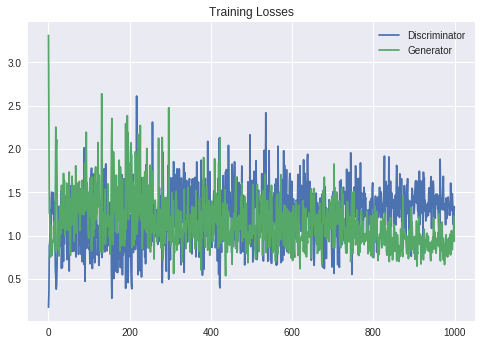

In [0]:
losses = np.array(losses)

fig, ax = plt.subplots()
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

In [0]:
latent_samples = make_latent_samples(20, sample_size)
generated_recipes = generator.predict(latent_samples)

for i in range(20):
    recipe = deprocess(generated_recipes[i])
    original_recipe = full_decode_to_original(recipe, flat_ingredients, flat_steps)
    print(json.dumps(original_recipe, indent=2))
    

{
  "ingredients": [
    "McCormick\u00ae Ginger, Ground, divided",
    "Thai-style peanut sauce",
    "honeydew melon, halved and seeded",
    "bag frozen bell pepper strips",
    "green onions, thinly sliced (plus extra for garnish)",
    "sliced or cut up fresh fruit, such as strawberries, peaches, nectarines and/or kiwi fruit",
    "ears fresh corn, kernels cut off"
  ],
  "steps": [
    "Spoon fruit over crepes",
    "Sprinkle cheese over mayonnaise, then top with bacon bits, if using",
    "Mix together the beef broth and tomato paste and pour into the slow cooker along with the beer",
    "Combine lime zest, lime juice, sugar and water",
    "Cool cake on a rack, and frost with a lemon butter icing",
    "Cook over moderate heat, covered, until the vegetables start to soften, 5 to 10 minutes",
    "Stir in the tomato paste and then the tomatoes and cayenne"
  ]
}
{
  "ingredients": [
    "Pepperidge Farm\u00ae Cinnamon Swirl Bread , cut into cubes",
    "blueberries, halved cros